In [83]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [84]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [85]:
last_skywalker = np.array([0.98, 0.9, -0.9])

In [86]:
user1 = np.array([0.9, 0.8, -0.6])

In [87]:
(user1 * last_skywalker).sum()

np.float64(2.1420000000000003)

In [88]:
casablanca = np.array([-0.99, -0.3, 0.8])

In [89]:
(user1 * casablanca).sum()

np.float64(-1.611)

In [90]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [91]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [92]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,847,Amadeus (1984),4
1,71,"Time to Kill, A (1996)",3
2,263,Dead Poets Society (1989),4
3,339,"Crying Game, The (1992)",5
4,298,"Wings of the Dove, The (1997)",3
5,500,Cinema Paradiso (1988),5
6,303,"Birds, The (1963)",4
7,593,GoodFellas (1990),2
8,608,Stand by Me (1986),5
9,538,Full Metal Jacket (1987),4


In [93]:
dls.classes

{'user': ['#na#', np.int16(1), np.int16(2), np.int16(3), np.int16(4), np.int16(5), np.int16(6), np.int16(7), np.int16(8), np.int16(9), np.int16(10), np.int16(11), np.int16(12), np.int16(13), np.int16(14), np.int16(15), np.int16(16), np.int16(17), np.int16(18), np.int16(19), np.int16(20), np.int16(21), np.int16(22), np.int16(23), np.int16(24), np.int16(25), np.int16(26), np.int16(27), np.int16(28), np.int16(29), np.int16(30), np.int16(31), np.int16(32), np.int16(33), np.int16(34), np.int16(35), np.int16(36), np.int16(37), np.int16(38), np.int16(39), np.int16(40), np.int16(41), np.int16(42), np.int16(43), np.int16(44), np.int16(45), np.int16(46), np.int16(47), np.int16(48), np.int16(49), np.int16(50), np.int16(51), np.int16(52), np.int16(53), np.int16(54), np.int16(55), np.int16(56), np.int16(57), np.int16(58), np.int16(59), np.int16(60), np.int16(61), np.int16(62), np.int16(63), np.int16(64), np.int16(65), np.int16(66), np.int16(67), np.int16(68), np.int16(69), np.int16(70), np.int16(71

In [94]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [95]:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3

tensor([-0.8223,  0.9201, -1.4968, -0.1452,  0.2560])

In [96]:
user_factors[3]

tensor([-0.8223,  0.9201, -1.4968, -0.1452,  0.2560])

In [97]:
class Example:
    def __init__(self, a): self.a = a
    def say(self, x): return f'Hello {self.a}, {x}.'

In [98]:
ex = Example('sylvian')
ex.say('nice to meet you')

'Hello sylvian, nice to meet you.'

### Colaborative filtering from scratch

In [99]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [100]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [101]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [102]:
learn.fit_one_cycle(5, 5e-3)

epoch     train_loss  valid_loss  time    
0         1.308260    1.336055    00:03                                                      
1         1.064737    1.116552    00:03                                                      
2         0.855042    1.024052    00:03                                                      
3         0.781739    0.922519    00:03                                                      
4         0.756479    0.898652    00:03                                                      


In [103]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[: ,0])
        movies = self.movie_factors(x[:, 1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [104]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch     train_loss  valid_loss  time    
0         0.959648    1.015247    00:03                                                      
1         0.655005    0.966513    00:03                                                      
2         0.438737    0.973854    00:03                                                      
3         0.355870    0.975561    00:03                                                      
4         0.332991    0.974425    00:03                                                      


In [105]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:, 0]) + self.movie_bias(x[:, 1])
        return sigmoid_range(res, *self.y_range)

In [106]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch     train_loss  valid_loss  time    
0         0.856885    0.965199    00:03                                                      
1         0.581820    0.928996    00:03                                                      
2         0.397083    0.964137    00:03                                                      
3         0.318437    0.974873    00:03                                                      
4         0.298544    0.973682    00:03                                                      


In [145]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch     train_loss  valid_loss  time    
0         0.873800    0.959395    00:03                                                      
1         0.652936    0.909634    00:03                                                      
2         0.521670    0.889823    00:04                                                      
3         0.454515    0.873741    00:04                                                      
4         0.423561    0.870104    00:03                                                      


### Custom embedding module

In [108]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [109]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [110]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.2303],
        [ 0.8014],
        [ 0.1789]], requires_grad=True)]

In [111]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [112]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [113]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [114]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch     train_loss  valid_loss  time    
0         0.886700    0.970950    00:03                                                      
1         0.653383    0.911660    00:04                                                      
2         0.547261    0.886788    00:03                                                      
3         0.447851    0.870532    00:03                                                      
4         0.434954    0.866370    00:03                                                      


In [115]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Home Alone 3 (1997)',
 'Mortal Kombat: Annihilation (1997)',
 'Free Willy 3: The Rescue (1997)']

In [116]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'As Good As It Gets (1997)',
 'Silence of the Lambs, The (1991)']

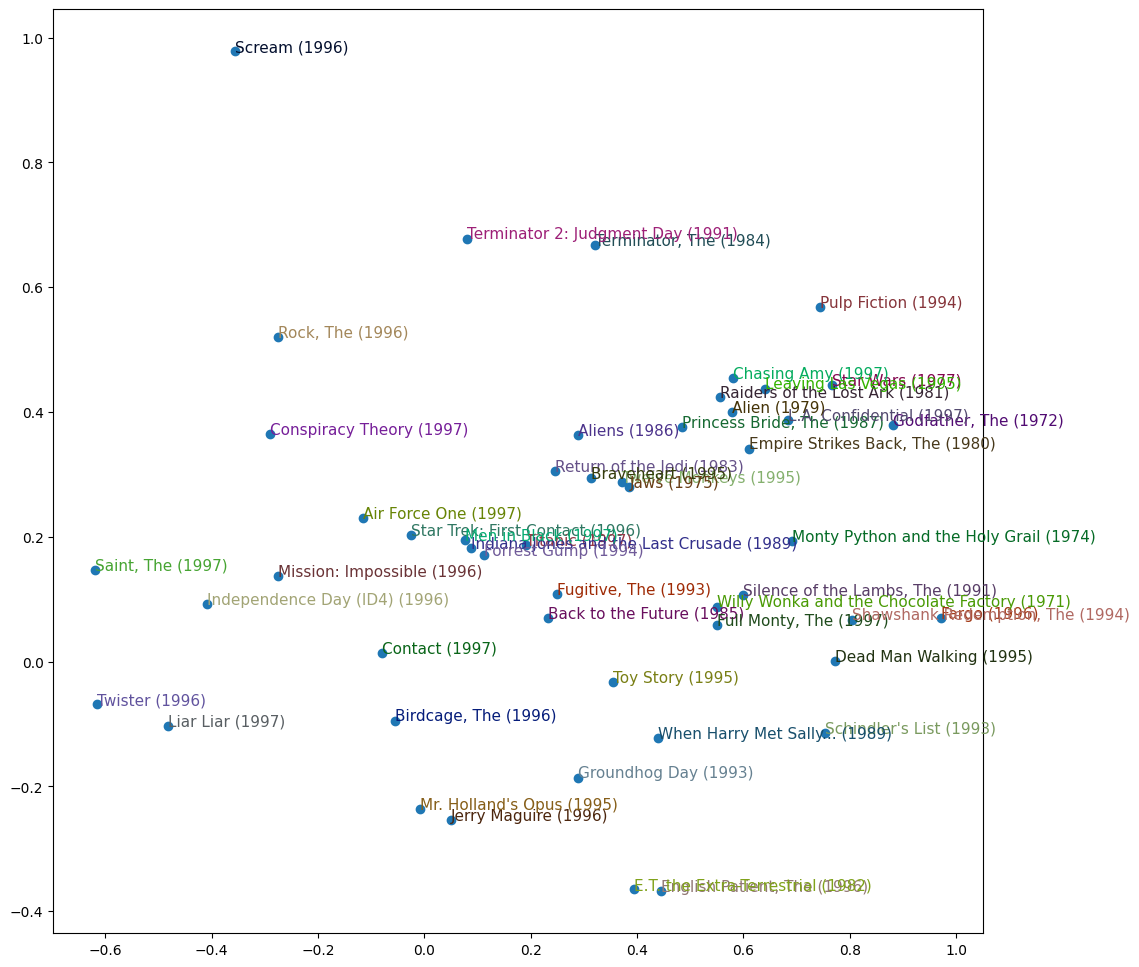

In [117]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12, 12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color = np.random.rand(3)*0.7, fontsize = 11)

plt.show()

### with fastai.collab

In [146]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch     train_loss  valid_loss  time    
0         0.882534    0.967901    00:04                                                      
1         0.676533    0.908825    00:03                                                      
2         0.528417    0.880204    00:03                                                      
3         0.457784    0.865092    00:03                                                      
4         0.434124    0.861010    00:04                                                      


In [119]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [120]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'As Good As It Gets (1997)',
 'Rear Window (1954)',
 'Star Wars (1977)']

### most similar movie to *Silence of the Lambs*

In [121]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Glory (1989)'

### Deep Learning

In [134]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [135]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [136]:
model = CollabNN(*embs)

In [137]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch     train_loss  valid_loss  time    
0         0.931913    0.991329    00:04                                                      
1         0.893424    0.929678    00:03                                                      
2         0.810297    0.931114    00:03                                                      
3         0.778714    0.907480    00:03                                                      
4         0.737109    0.899397    00:03                                                      


In [138]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100, 50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch     train_loss  valid_loss  time    
0         0.933713    0.995710    00:04                                                      
1         0.881542    0.944265    00:04                                                      
2         0.827784    0.924821    00:04                                                      
3         0.746985    0.902406    00:04                                                      
4         0.772681    0.899488    00:04                                                      


### How this looks in fastai's code

In [140]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)